### Introduction:

The main purpose of this presentation is to highlight three of the most interesting findings in the data. While some preprocessing and feature engineering steps will be included, they will not be explained in detail, as all comments, ideas, and thoughts are thoroughly documented in the comprehensive EDA file. Additionally, this presentation does not cover the identification of the most important features or the machine learning aspects.

In [2]:
#Import for data processing and vizualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# Import for ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# File path to the CSV data
file_path = r'C:\Users\mryok\OneDrive\Рабочий стол\New folder\df_players.csv'

# Read the CSV file with appropriate parameters
df = pd.read_csv(
    file_path,
    sep=';',                       # Use semicolon as the delimiter
    quotechar='"',                 # Use double quotes as the quote character
    header=0,                      # First row is the header
    skipinitialspace=True,         # Skip any spaces after delimiters
    index_col=0                    # Use the first column as the index (if desired)
)

In [3]:
# Function to unify values to integers in cloumn with value_eurs
def convert_float(value):
    # Replace commas with dots to handle decimal separators
    value = value.replace(',', '.')
    try:
        return float(value)
    except ValueError:
        return None

# Apply the conversion function to the 'value_eur' column
df['value_eur'] = df['value_eur'].apply(convert_float)
# Create a new binary column 'has_tags' where 1 indicates the player has tags, and 0 indicates no tags.
df['has_tags'] = df['player_tags'].notna().astype(int)
# Replace any missing values in the 'player_tags' column with the string 'No Tag'.
df['player_tags'] = df['player_tags'].fillna('No Tag')
# Clean up the 'player_tags' column by removing any '#' characters and non-breaking spaces ('\xa0').
df['player_tags'] = df['player_tags'].apply(lambda x: x.replace('#', '').replace('\xa0', ''))

def impute_missing_with_median(df, columns):
    """
    Fills missing values in specified columns with the median of each column.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list of str): The list of column names to apply median imputation.
    
    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """
    for column in columns:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)
    return df

# List of columns to impute
columns_to_impute = ['pace', 'shooting', 'passing', 'dribbling', 'defending','physic']

# Apply the function to the DataFrame
df = impute_missing_with_median(df, columns_to_impute)

# Calculate the BMI and create a new column
df['bmi'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)
# Experience Level
# Define age brackets
def categorize_age(age):
    if age < 23:
        return 'Young'
    elif 23 <= age < 30:
        return 'Prime'
    else:
        return 'Veteran'

# Apply categorization
df['age_category'] = df['age'].apply(categorize_age)
# Age-Potential Ratio
df['potential_chance'] = df['potential'] / df['age']
# Skill score
df['skill_score'] = df[['pace', 'shooting', 'passing', 'dribbling', 'defending']].mean(axis=1)

## Top 3 Most Interesting Cases:

### Case Number 1: Ukrainian league as a doubt for analysis

**Motivation:** 
Starting the research from a broad perspective—League level → Club level → Personal characteristics of players—I encountered some confusion. 

As someone from Ukraine who is not deeply involved in football, I am aware of the negative perceptions surrounding the Ukrainian league :)

To investigate, I first extracted data for the top 10 leagues based on the highest average `value_eur` per player. The leagues included must have crucial characteristics to meet this requirement. However, a potential issue is that the number of players in each league varies. 
More relevant results can be obtained at the club level, but further details are available in the comprehensive EDA file.

In [252]:
# Assuming df is your DataFrame and the previous operations have been performed:
league_stats = df.groupby('league_name').agg(
    mean_value_eur=('value_eur', 'mean'),
    player_count=('value_eur', 'size')
).reset_index()

# Calculate mean value per player
league_stats['mean_value_per_player'] = league_stats['mean_value_eur'] / league_stats['player_count']

# Sort by mean value per player and select the top 10 leagues
top_leagues = league_stats.sort_values(by='mean_value_per_player', ascending=False)

# Plot using Plotly
fig = px.bar(
    top_leagues, 
    x='mean_value_per_player', 
    y='league_name', 
    orientation='h', 
    title='Top 10 Leagues by Mean Value Per Player',
    labels={'mean_value_per_player': 'Mean Value Per Player (€)', 'league_name': 'League Name'},
    color='mean_value_per_player',
    color_continuous_scale='Viridis'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Mean Value Per Player (€)",
    yaxis_title="League Name",
    title_x=0.5,
    yaxis=dict(categoryorder='total ascending')
)

# Show the plot
fig.show()

# Assuming df is your DataFrame
# Group by league_name and count the number of players in each league
league_player_counts = df.groupby('league_name').agg(player_count=('sofifa_id', 'count')).reset_index()

# Sort the leagues by the number of players in descending order and select the top 10
top_leagues_by_player_count = league_player_counts.sort_values(by='player_count', ascending=False).head(15)

# Plot using Plotly
fig = px.bar(
    top_leagues_by_player_count, 
    x='player_count', 
    y='league_name', 
    orientation='h', 
    title='Top 10 Leagues by Number of Players',
    labels={'player_count': 'Number of Players', 'league_name': 'League Name'},
    color='player_count',
    color_continuous_scale='Blues'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Number of Players",
    yaxis_title="League Name",
    title_x=0.5,
    yaxis=dict(categoryorder='total ascending')
)

# Show the plot
fig.show()

# Group by league_name and calculate the average potential_chance in each league
league_skill_score = df.groupby('league_name').agg(avg_skill_score=('skill_score', 'mean')).reset_index()

# Sort the leagues by the average potential_chance in descending order and select the top 10
top_leagues_by_skill_score = league_skill_score.sort_values(by='avg_skill_score', ascending=False).head(10)

# Plot using Plotly
fig = px.bar(
    top_leagues_by_skill_score, 
    x='avg_skill_score', 
    y='league_name', 
    orientation='h', 
    title='Top 10 Leagues by Average Potential Chance',
    labels={'avg_skill_score': 'Average Skill Score', 'league_name': 'League Name'},
    color='avg_skill_score',
    color_continuous_scale='Viridis'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Average Skill Score",
    yaxis_title="League Name",
    title_x=0.5,
    yaxis=dict(categoryorder='total ascending')
)

# Show the plot
fig.show()

Summary:
- The top 10 leagues with the highest average player value are: **Ukrainian Premier League** (what was strange as for me, keeping in mind historical facts about this ligue), Hungarian Nemzeti Bajnokság I, Croatian Prva HNL, Russian Premier League, UAE Arabian Gulf League, Czech Republic Gambrinus Liga, Cypriot First Division, English Premier League, Greek Super League, and Spain's Primera División.
- The top 10 leagues by the number of players are: USA Major League Soccer, Argentina Primera División, Spain's Primera División, French Ligue 1, English Premier League, Japanese J. League Division 1, Italian Serie A, Turkish Süper Lig, Portuguese Liga ZON SAGRES, and Campeonato Brasileiro Série A.

#### Top 10 Leagues based on average potential and potential chance

**Objective:**
To identify the top 10 leagues based on the average values for two key metrics: `potential` and `potential_chance`.

In [4]:
# Calculate the average potential and potential chance for each league
league_stats = df.groupby('league_name').agg(
    avg_potential=('potential', 'mean'),
    avg_potential_chance=('potential_chance', 'mean')
).reset_index()

# Sort the leagues by average potential and potential chance, and select the top 10
top_10_leagues_by_potential = league_stats.sort_values(by='avg_potential', ascending=False).head(10)
top_10_leagues_by_potential_chance = league_stats.sort_values(by='avg_potential_chance', ascending=False).head(10)

# Top 10 Leagues by Average Potential
fig1 = px.bar(
    top_10_leagues_by_potential,
    x='avg_potential',
    y='league_name',
    orientation='h',
    title='Top 10 Leagues by Average Potential',
    labels={'avg_potential': 'Average Potential', 'league_name': 'League Name'},
    color='avg_potential',
    color_continuous_scale='Blues'
)

# Top 10 Leagues by Average Potential Chance
fig2 = px.bar(
    top_10_leagues_by_potential_chance,
    x='avg_potential_chance',
    y='league_name',
    orientation='h',
    title='Top 10 Leagues by Average Potential Chance',
    labels={'avg_potential_chance': 'Average Potential Chance', 'league_name': 'League Name'},
    color='avg_potential_chance',
    color_continuous_scale='Reds'
)

# Show the plots
fig1.show()
fig2.show()

Considering the metrics of potential and potential chance, the English Premier League ranks highest in terms of average potential. In contrast, the Ukrainian Premier League leads in potential chance. This is particularly encouraging and noteworthy.

I decided to dive deeper into the characteristics to gain a more detailed understanding. This involves a thorough examination of the key features and metrics to uncover valuable insights and trends.

In [254]:
ukrainian_premier_league_df = df[df['league_name'] == 'Ukrainian Premier League']
# Display the extracted data
ukrainian_premier_league_df.describe()

,sofifa_id,overall,potential,age,height_cm,weight_kg,club_contract_valid_until,pace,shooting,passing,dribbling,defending,physic,value_eur,has_tags,bmi,potential_chance,skill_score
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,2.200000e+01,22.000000,22.000000,22.000000,22.000000
mean,231110.818182,74.590909,79.681818,25.454545,180.454545,76.090909,2023.727273,75.227273,58.272727,65.136364,69.181818,59.409091,66.636364,9.037500e+06,0.090909,23.374926,3.265158,65.445455
std,27397.624505,3.389888,4.133330,5.179881,7.235674,6.704008,1.453463,7.204045,15.787825,9.958464,10.069456,16.612271,8.150638,7.951130e+06,0.294245,1.692191,0.720267,6.595794
min,142902.000000,68.000000,73.000000,18.000000,166.000000,67.000000,2021.000000,64.000000,22.000000,38.000000,45.000000,29.000000,52.000000,6.250000e+05,0.000000,20.679012,2.027027,49.000000
25%,223093.000000,72.250000,76.250000,21.250000,175.500000,71.250000,2023.000000,70.000000,47.500000,59.500000,63.750000,45.500000,59.250000,3.650000e+06,0.000000,22.252009,2.558954,61.700000
50%,239535.000000,74.500000,79.500000,23.500000,180.000000,76.000000,2023.000000,75.000000,64.500000,65.500000,69.000000,65.500000,69.000000,5.250000e+06,0.000000,23.190853,3.342391,65.700000
75%,246775.250000,76.000000,82.750000,29.750000,185.250000,80.000000,2025.000000,80.500000,69.750000,72.000000,78.000000,72.750000,72.750000,1.525000e+07,0.000000,24.352377,3.806818,69.700000
max,258781.000000,81.000000,86.000000,37.000000,197.000000,92.000000,2026.000000,88.000000,76.000000,78.000000,86.000000,79.000000,79.000000,3.350000e+07,1.000000,27.450605,4.555556,75.200000


In [255]:
french_premier_league_df = df[df['league_name'] == 'French Ligue 1']
# Display the extracted data
french_premier_league_df.describe()

,sofifa_id,overall,potential,age,height_cm,weight_kg,club_contract_valid_until,pace,shooting,passing,dribbling,defending,physic,value_eur,has_tags,bmi,potential_chance,skill_score
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,2.200000e+02,220.000000,220.000000,220.000000,220.000000
mean,222035.518182,75.345455,78.940909,25.900000,181.231818,74.645455,2023.418182,70.463636,58.631818,66.154545,70.804545,60.527273,70.745455,1.279727e+07,0.181818,22.699415,3.145717,65.316364
std,25375.073230,4.498475,4.424007,4.388549,7.060462,7.169935,1.149801,12.746332,14.460966,8.634841,8.614683,16.998635,7.830903,2.084381e+07,0.386574,1.377124,0.616825,6.424433
min,124375.000000,65.000000,69.000000,17.000000,164.000000,58.000000,2022.000000,32.000000,27.000000,39.000000,45.000000,19.000000,45.000000,4.250000e+05,0.000000,19.444444,1.945946,47.200000
25%,207797.000000,73.000000,76.000000,23.000000,176.000000,69.750000,2022.000000,65.000000,48.000000,61.000000,66.000000,48.500000,67.000000,3.075000e+06,0.000000,21.714832,2.714286,62.000000
50%,227761.000000,75.000000,79.000000,25.000000,181.000000,73.000000,2023.000000,71.500000,58.500000,67.000000,72.000000,67.000000,70.000000,6.500000e+06,0.000000,22.683626,3.113571,65.400000
75%,239699.750000,78.000000,82.000000,29.000000,187.000000,80.000000,2024.000000,78.000000,70.000000,72.000000,76.000000,73.000000,76.250000,1.500000e+07,0.000000,23.629490,3.576299,69.450000
max,262908.000000,93.000000,95.000000,37.000000,197.000000,93.000000,2026.000000,97.000000,92.000000,91.000000,95.000000,89.000000,86.000000,1.940000e+08,1.000000,26.528510,4.823529,80.600000


#### Analysis of Player Characteristics in the French and Ukrainian Leagues

The total number of players is significantly higher in the French league (Spoiler: the most valuable player is from this league), with only minor differences observed in the remaining parameters. Notably, the potential chance for the Ukrainian Premier League is approximately 0.12 points higher.

After examining these characteristics, we observe that the mean `potential_chance` (the likelihood for players to reach their maximum potential) is nearly the same across both leagues. Additionally, the mean age of players in the French league is approximately 0.5 years older, which could also influence the `potential_chance`. Despite this, the overall `potential` is about 5 points higher in the French league, and `potential` itself is around 0.7 points higher.

Similarly, there is no significant difference in the `skill_score` (a metric encompassing various playing skills like defense, attack, etc.). This suggests that the metrics were calculated correctly and are relevant to the overall statistical estimation. Based on this analysis, I will reconsider my initial views regarding the Ukrainian league :)

### Case number 2: Identifying the Highest Potential MVP Candidates and MVP Potential Relative to Value_eur

The second case focused on player statistics. I analyzed the top 15 best and top 10 worst players to understand the factors influencing their value (`value_eur`). This investigation helped to identify which features most significantly impact a player’s `value_eur` and provided insights into potential MVP candidates.

Top most valuable players in the dataset

In [ ]:
# Assuming df is your DataFrame, sort the players by value_eur and select the top 10
top_players = df.sort_values(by='value_eur', ascending=False).head(10)

# Plot using Plotly
fig = px.bar(
    top_players, 
    x='value_eur', 
    y='short_name', 
    color='club_name',
    orientation='h',
    title='Top 10 Players by Market Value (€)',
    labels={'value_eur': 'Market Value (€)', 'short_name': 'Player Name', 'club_name': 'Club Name'},
    color_continuous_scale='Magma'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Market Value (€)",
    yaxis_title="Player Name",
    title_x=0.5,
    yaxis=dict(categoryorder='total ascending')
)

# Show the plot
fig.show()

- According to the analysis, the most expensive player is Kylian Mbappé, playing for Paris Saint-Germain (PSG), with a valuation of €194M.
- In second place is Erling Haaland, playing for Borussia Dortmund, valued at €137M.
- The third most valuable player is Harry Kane, representing Tottenham Hotspur, with a valuation of €129.5M.

Notably, there is a significant difference in value between Mbappé and Haaland. This disparity presents an opportunity for further investigation to understand the factors influencing player valuation and pricing strategies.

In [265]:
player_name = df[['short_name',
                  'value_eur',
                    'overall',
                    'potential',
                    'age',
                    'club_name',
                    'club_contract_valid_until',
                    'preferred_foot',
                    'bmi',
                    'formation',
                    'age_category',
                    'potential_chance',
                    'skill_score'
                  ]].nlargest(15,['value_eur']).set_index('short_name')
player_name

,value_eur,overall,potential,age,club_name,club_contract_valid_until,preferred_foot,bmi,formation,age_category,potential_chance,skill_score
short_name,,,,,,,,,,,,
K. Mbappé,194000000.0,91,95,22,Paris Saint-Germain,2022,Right,22.038401,att,Young,4.318182,78.6
E. Haaland,137500000.0,88,93,20,Borussia Dortmund,2024,Left,24.976087,att,Young,4.650000,74.0
H. Kane,129500000.0,90,90,27,Tottenham Hotspur,2024,Right,25.181077,att,Prime,3.333333,74.8
Neymar Jr,129000000.0,91,91,29,Paris Saint-Germain,2025,Right,22.204082,att,Prime,3.137931,78.2
K. De Bruyne,125500000.0,91,91,30,Manchester City,2025,Right,21.366869,mid,Veteran,3.033333,81.4
G. Donnarumma,119500000.0,89,93,22,Paris Saint-Germain,2026,Right,23.427738,GK,Young,4.227273,63.2
F. de Jong,119500000.0,87,92,24,FC Barcelona,2026,Right,22.839506,mid,Prime,3.833333,80.0
R. Lewandowski,119500000.0,92,92,32,FC Bayern München,2023,Right,23.666910,att,Veteran,2.875000,75.8
J. Sancho,116500000.0,87,91,21,Manchester United,2026,Right,23.456790,mid,Young,4.333333,73.2


Summary of Top 15 Football Players:
- The analysis of the top 15 football players reveals that most prefer using their right foot. Kylian Mbappé is the most valuable player, valued at €194M, with an overall rating of 91 and a potential of 95. Playing for Paris Saint-Germain, he is also one of the youngest players at just 22 years old. His high potential and young age contribute to his high value. Mbappé is the youngest right-footed player among the top and has a high potential chance, which, along with his exceptional skill score, makes him the most valuable player on the list.
- Kevin De Bruyne has the highest skill score among the top 15 players. However, his potential chance is slightly lower due to his age of 30, compared to Mbappé's 22 years.
- Erling Haaland and Harry Kane are the second and third most valuable players, valued at €137.5M and €129.5M, respectively. Haaland, who is 20 years old and has a potential of 93, is a highly promising talent. Notably, Haaland is the only left-footed player among the top 15.
- Neymar Jr and Kevin De Bruyne, valued around €129M and €125.5M respectively, are among the older players in this group but maintain high overall ratings of 91. They play for top clubs Paris Saint-Germain and Manchester City.
- Gianluigi Donnarumma and Jadon Sancho are also significant due to their high potential ratings (93 and 91, respectively) at a young age, indicating future growth and sustained value.
- Robert Lewandowski, Joshua Kimmich, and Bruno Fernandes are key figures at their clubs, FC Bayern München and Manchester United, with values ranging from €108M to €119.5M.
- Jan Oblak and Rúben Dias are strong defensive players, valued between €102.5M and €112M, and make substantial contributions to Atlético de Madrid and Manchester City.
- Rúben Dias has the highest club contract value, which may also influence his overall value.
- Although Haaland is one of the more experienced players, he has a skill score of 74.0, which is among the lowest for the top 15.
- Robert Lewandowski, despite having the highest overall rating, is 32 years old, making him the oldest player in the group. His age impacts his potential, resulting in a lower potential chance.

P.S. To confirm these trends, the most important features will be identified using machine learning techniques at the end of the investigation.

A good question to ask is: Who is the worst player? To answer this, let's identify the top 10 worst players based on value_eur. Since this metric reflects the quality of a player's stats, it serves as a reliable indicator of player performance.

In [260]:
# Assuming df is your DataFrame, sort the players by value_eur and select the top 10
top_players = df.sort_values(by='value_eur', ascending=True).head(10)

# Plot using Plotly
fig = px.bar(
    top_players, 
    x='value_eur', 
    y='short_name', 
    color='club_name',
    orientation='h',
    title='Top 10 Players by Market Value (€)',
    labels={'value_eur': 'Market Value (€)', 'short_name': 'Player Name', 'club_name': 'Club Name'},
    color_continuous_scale='Magma'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Market Value (€)",
    yaxis_title="Player Name",
    title_x=0.5,
    yaxis=dict(categoryorder='total ascending')
)

# Show the plot
fig.show()

The player with the lowest value_eur is Liu Zhenli, who plays for Qingdao FC.

In [263]:
player_name = df[['short_name',
                  'value_eur',
                    'overall',
                    'potential',
                    'age',
                    'club_name',
                    'club_contract_valid_until',
                    'preferred_foot',
                    'bmi',
                    'formation',
                    'age_category',
                    'potential_chance',
                    'skill_score'
                  ]].nsmallest(15,['value_eur']).set_index('short_name')
player_name

,value_eur,overall,potential,age,club_name,club_contract_valid_until,preferred_foot,bmi,formation,age_category,potential_chance,skill_score
short_name,,,,,,,,,,,,
Liu Zhenli,25000.0,58,58,36,Qingdao FC,2021,Right,25.773196,GK,Veteran,1.611111,63.2
S. Roy,35000.0,58,58,34,NorthEast United FC,2022,Right,23.888441,GK,Veteran,1.705882,63.2
B. Murphy,35000.0,61,61,38,Waterford FC,2021,Right,24.784258,GK,Veteran,1.605263,63.2
Huang Xiyang,35000.0,54,54,36,Chongqing Liangjiang Athletic,2022,Right,22.093170,mid,Veteran,1.500000,53.6
Yao Hanlin,45000.0,56,56,36,Wuhan FC,2021,Right,19.591837,mid,Veteran,1.555556,51.6
A. Edathodika,45000.0,56,56,34,Jamshedpur FC,2022,Right,24.074074,def,Veteran,1.647059,40.8
B. Singh,45000.0,53,53,34,SC East Bengal FC,2022,Right,23.148148,att,Veteran,1.558824,44.8
S. Lukić,50000.0,63,63,41,Varbergs BoIS FC,2021,Right,24.685330,GK,Veteran,1.536585,63.2
Li Shuai,50000.0,63,63,38,Shanghai Shenhua FC,2021,Right,23.624795,GK,Veteran,1.657895,63.2


Key Insights:
- Veteran Players: All players (except of one) in this group fall into the Veteran category, indicating they are in the later stages of their careers.
- Age Demographics: The majority of these players are over 30 years old, reflecting their veteran status.
- Preferred Foot: A consistent preference for playing with the right foot is observed across all players.
- Performance Metrics: The players exhibit relatively low potential and other key stats, which correlates with their lower market value (value_eur).

These factors collectively explain the reduced market valuation of these players.

Additional attantion was dedictaed to possible impact of prefered foot to potential in the game

Right Foot Preference Mean Statistics:
potential           72.549811
skill_score         61.168760
potential_chance     2.776563
dtype: float64

Left Foot Preference Mean Statistics:
potential           72.624487
skill_score         62.099453
potential_chance     2.789509
dtype: float64


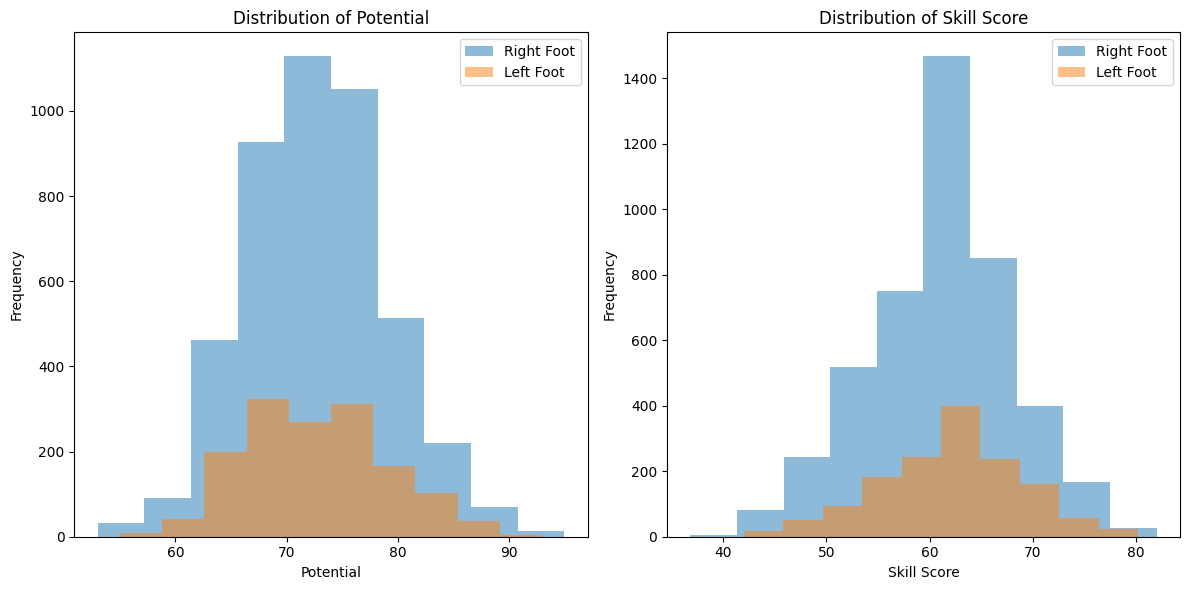

In [227]:
# Separate data by foot preference
right_foot = df[df['preferred_foot'] == 'Right']
left_foot = df[df['preferred_foot'] == 'Left']

# Calculate mean for right-foot players
right_foot_mean = right_foot[['potential', 'skill_score', 'potential_chance']].mean()

# Calculate mean for left-foot players
left_foot_mean = left_foot[['potential', 'skill_score', 'potential_chance']].mean()

# Print mean statistics
print("Right Foot Preference Mean Statistics:")
print(right_foot_mean)
print("\nLeft Foot Preference Mean Statistics:")
print(left_foot_mean)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Potential
plt.subplot(1, 2, 1)
plt.hist(right_foot['potential'], alpha=0.5, label='Right Foot', bins=10)
plt.hist(left_foot['potential'], alpha=0.5, label='Left Foot', bins=10)
plt.title('Distribution of Potential')
plt.xlabel('Potential')
plt.ylabel('Frequency')
plt.legend()

# Plot Skill Score
plt.subplot(1, 2, 2)
plt.hist(right_foot['skill_score'], alpha=0.5, label='Right Foot', bins=10)
plt.hist(left_foot['skill_score'], alpha=0.5, label='Left Foot', bins=10)
plt.title('Distribution of Skill Score')
plt.xlabel('Skill Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

While the differences in mean values between right-footed and left-footed players are relatively small, left-footed players tend to have marginally higher potential, skill scores, and potential chances. These differences, though statistically noticeable, may not be substantial enough to significantly impact player evaluations in practical scenarios.

And now we move on to this case:

In [228]:
# Define a function to plot top 10 players for each attribute
def plot_top_10(df, attribute):
    # Sort by the attribute and get the top 10 players
    top_10 = df.nlargest(10, attribute)
    
    # Create a bar plot
    fig = px.bar(
        top_10,
        x='short_name',
        y=attribute,
        title=f'Top 10 Players by {attribute.capitalize()}',
        labels={'short_name': 'Player', attribute: f'{attribute.capitalize()} Rating'},
        color=attribute,
        color_continuous_scale='Viridis'
    )
    fig.update_layout(
        xaxis_title='Player',
        yaxis_title=f'{attribute.capitalize()} Rating',
        title_x=0.5,
        xaxis_tickangle=-45
    )
    fig.show()

# Plot top 10 for each attribute
for attr in ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']:
    plot_top_10(df, attr)

Among the players excelling in key performance categories, we have:

- **Pace:** Kylian Mbappé
- **Shooting:** Cristiano Ronaldo
- **Dribbling:** Lionel Messi
- **Defending:** Virgil van Dijk
- **Physical Attributes:** Casemiro

Each of these players stands out in their respective domains, significantly contributing to their teams' overall performance. Their standout attributes make them invaluable assets:

- **Kylian Mbappé** brings unmatched pace to the attack, exploiting spaces behind defenders and creating goal-scoring opportunities.
- **Cristiano Ronaldo** excels in finishing and goal-scoring, consistently converting chances into goals and being a reliable frontman.
- **Lionel Messi** provides creative playmaking and exceptional dribbling, maneuvering through tight spaces and orchestrating attacks.
- **Virgil van Dijk** offers defensive solidity and leadership, preventing opponents from scoring and maintaining a strong defensive line.
- **Casemiro** ensures physical dominance and midfield control, excelling in battles, winning aerial duels, and covering large areas of the pitch effectively.

**Possible MVP:**

Considering their contributions and impact on their teams, **Lionel Messi** could be a strong candidate for the MVP title. His unparalleled dribbling and creative playmaking, combined with his consistent performance and influence on the game, make him a standout choice.

Let's investigate why the most likely MVP player has a lower `value_eur` than the top player in the dataset.


In [230]:
# List of player names to extract
players = ['L. Messi', 'K. Mbappé']

# Extract data for the specified players
df_filtered = df[df['short_name'].isin(players)]

# Display the extracted data
df_filtered

,sofifa_id,short_name,overall,potential,age,height_cm,weight_kg,club_name,league_name,club_contract_valid_until,...,defending,physic,formation,player_tags,value_eur,has_tags,bmi,age_category,potential_chance,skill_score
5427,158023,L. Messi,93,93,34,170,72,Paris Saint-Germain,French Ligue 1,2023,...,34.0,65.0,att,"Dribbler, Distance Shooter, FK Specialist, Acr...",78000000.0,1,24.913495,Veteran,2.735294,79.4
5694,231747,K. Mbappé,91,95,22,182,73,Paris Saint-Germain,French Ligue 1,2022,...,36.0,77.0,att,"Speedster, Dribbler, Acrobat, Clinical Finishe...",194000000.0,1,22.038401,Young,4.318182,78.6


Despite having a higher overall rating, Kylian Mbappé's potential is 2 points higher than Lionel Messi's. Additionally, Mbappé is classified as "Young," whereas Messi falls into the "Veteran" category, which limits Messi's potential.

In terms of skill score, the difference between the two players is minimal. However, Mbappé’s younger age—12 years younger than Messi—significantly contributes to his higher potential chance. Both players are in the same league and club, making this comparison particularly relevant.

In summary, Kylian Mbappé is the more valuable player due to his higher potential and younger age and in turn more potential to be MVP.

### Case number 3: Formation vs. Demand

The logic is as follows: the fewer players available in a specific position, the higher the demand for that role. This increased demand can drive up the `value_eur` of players who fill that position.


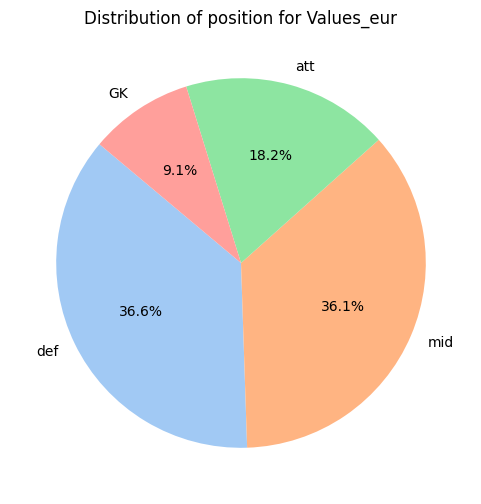

In [ ]:
top_wage = df.sort_values(by='value_eur',ascending=False)
position_counts = top_wage['formation'].value_counts()

# Plot Pie Chart
plt.figure(figsize=(6,6))
plt.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of position for Values_eur')
plt.show()

### Formation Statistics and Impact on Player Demand

- **Distribution of Formations:**
  - The distribution of formations reveals that the `def` (Defender) and `mid` (Midfielder) categories have similar percentages (36.6% and 36.1%, respectively). The `GK` (Goalkeeper) category has the lowest percentage, which could influence player demand. The `att` (Attacker) category comprises a moderate 18.2% of players. However, this distribution does not fully align with value trends.

- **Impact on Value_eur:**
  - Notably, among the top 10 players with the lowest `value_eur`, many are Goalkeepers (`GK`). Conversely, the top 4 players with the highest `value_eur` are predominantly from the Attacker (`att`) category. This suggests that players in attacking positions may experience higher demand and, consequently, higher market values, which influences overall player valuations.

So, the theory is partly supported by the data.